In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_handler import CoinDataStore
from src.simple_wash_detector_utils import detect_wash_trades_nearest
from src.simple_wash_detector_utils import detect_wash_trades_local

import warnings
warnings.filterwarnings("ignore")

In [2]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
sells = df_all_matched[["seller", "time", "price", "size"]].rename(columns={"seller": "wallet_id"}).copy()
sells["is_ask"] = True

buys = df_all_matched[["buyer", "time", "price", "size"]].rename(columns={"buyer": "wallet_id"}).copy()
buys["is_ask"] = False

df_all = pd.concat([sells, buys], ignore_index=True)

df_all["notional"] = df_all["price"] * df_all["size"]
df_all = df_all.groupby(["wallet_id", "time", "is_ask"]).agg(size=("size", "sum"), notional=("notional", "sum")).reset_index()
df_all["price"] = (df_all["notional"] / df_all["size"]).astype("float32")
df_all = df_all.drop("notional", axis=1)

In [3]:
df_all

,wallet_id,time,is_ask,size,price
0,1,2025-06-30 19:16:16.060,False,47.049999,18.014999
1,1,2025-06-30 19:16:46.011,False,47.049999,18.025000
2,1,2025-06-30 19:17:17.005,False,47.059998,18.030884
3,1,2025-06-30 19:17:46.024,False,47.049999,18.018999
4,1,2025-06-30 19:18:16.077,False,47.059998,18.011999
...,...,...,...,...,...
2265245,272404,2025-06-23 16:40:53.219,True,959.900024,16.377071
2265246,272404,2025-06-23 16:45:39.769,False,959.900024,16.470161
2265247,274311,2025-06-15 15:19:18.194,True,2.710000,19.183001
2265248,274311,2025-06-15 17:27:03.505,False,2.710000,19.049000


# Permutation

### Randomize time +-20 minutes

In [4]:
store = CoinDataStore("AVAX", engine="fastparquet")
time_diff_s = 5 * 60 # 1 minute difference
price_diff_pct = 0.01
size_diff_pct = 0.01

df_detected = detect_wash_trades_nearest(store, time_diff_s, price_diff_pct, size_diff_pct)
df_detected

,wallet_id,day,open_time,close_time,duration_s,open_side,close_side,open_price,close_price,price_change_pct,open_size,close_size,size_change_pct,pairing_direction,pair_id
0,8,2025-03-22,2025-03-22 12:22:36.650,2025-03-22 12:25:59.450,202.80,buy,sell,19.433001,19.415001,0.000926,1.010000,1.010000,0.000000e+00,buy_to_sell,0
1,8,2025-03-22,2025-03-22 13:48:26.900,2025-03-22 13:49:26.300,59.40,buy,sell,19.362000,19.357000,0.000258,0.790000,0.790000,0.000000e+00,buy_to_sell,1
2,8,2025-03-22,2025-03-22 19:43:30.450,2025-03-22 19:46:45.400,194.95,sell,buy,19.658001,19.635002,0.001170,42.290001,42.529999,5.675050e-03,sell_to_buy,2
3,8,2025-03-22,2025-03-22 20:10:04.500,2025-03-22 20:10:51.100,46.60,sell,buy,19.652000,19.658001,0.000305,6.960000,6.950000,1.436814e-03,sell_to_buy,3
4,8,2025-03-22,2025-03-22 21:06:57.250,2025-03-22 21:06:57.350,0.10,buy,sell,19.582001,19.582001,0.000000,9.430000,9.410000,2.120939e-03,buy_to_sell,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38359,34432,2025-07-27,2025-07-27 05:07:53.500,2025-07-27 05:08:13.550,20.05,sell,buy,25.028000,25.020069,0.000317,50.000000,50.000000,0.000000e+00,sell_to_buy,38359
38360,75319,2025-07-27,2025-07-27 05:47:51.700,2025-07-27 05:51:09.050,197.35,buy,sell,25.157833,25.119278,0.001533,384.740021,384.739990,7.932000e-08,buy_to_sell,38360
38361,168961,2025-07-27,2025-07-27 00:36:43.650,2025-07-27 00:37:53.850,70.20,buy,sell,24.940001,24.930000,0.000401,0.640000,0.640000,0.000000e+00,buy_to_sell,38361
38362,172595,2025-07-27,2025-07-27 07:57:57.800,2025-07-27 07:59:34.200,96.40,sell,buy,25.021999,25.038002,0.000640,0.400000,0.400000,0.000000e+00,sell_to_buy,38362


In [6]:
h0_volume = (df_detected["open_size"] + df_detected["close_size"]).sum()
h0_count = df_detected["open_size"].shape[0]

In [7]:
n_sim_time = []
def randomization(df):
    df["time"] = df["time"].apply(lambda x: x + datetime.timedelta(seconds = np.random.randint(-20 * 60, 20 * 60)))
    return df

In [9]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, randomization, is_final_filtration=False)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    n_sim_time.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.850		 - 0.935
1		 - 0.901		 - 0.934


In [ ]:
# before Binomial significance test filtration
# number	 - volume share	 - count share
# 0		 - 0.880		 - 0.927
# 1		 - 0.842		 - 0.926

### Randomize size of trade

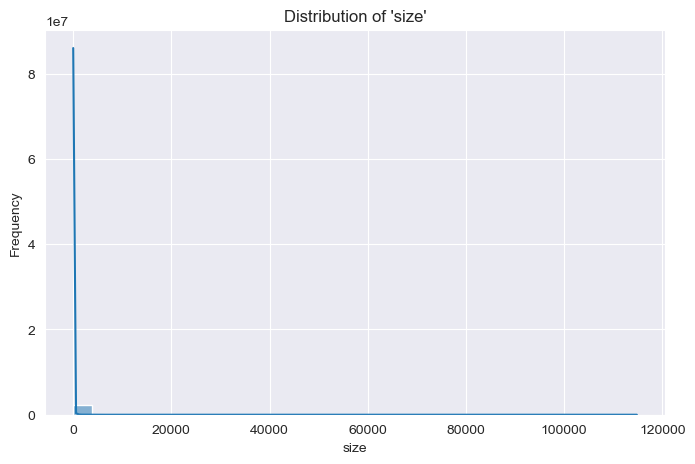

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

df = df_all.copy()
plt.figure(figsize=(8,5))
sns.histplot(df["size"], bins=30, kde=True)
plt.title("Distribution of 'size'")
plt.xlabel("size")
plt.ylabel("Frequency")
plt.show()


In [9]:
df = df.iloc[:1000].copy()
data = df["size"].dropna()

# Fit distributions
dist_names = ['norm', 'lognorm', 'expon', 'gamma']
results = []

for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(data)

    # Compute Kolmogorov–Smirnov test statistic
    ks_stat, ks_p = stats.kstest(data, dist_name, args=param)
    results.append((dist_name, ks_stat, ks_p))

# Sort by smallest KS statistic
results = sorted(results, key=lambda x: x[1])
for r in results:
    print(f"{r[0]:10s}  KS stat={r[1]:.4f},  p-value={r[2]:.4f}")


gamma       KS stat=0.0822,  p-value=0.0000
lognorm     KS stat=0.1202,  p-value=0.0000
expon       KS stat=0.1840,  p-value=0.0000
norm        KS stat=0.2583,  p-value=0.0000


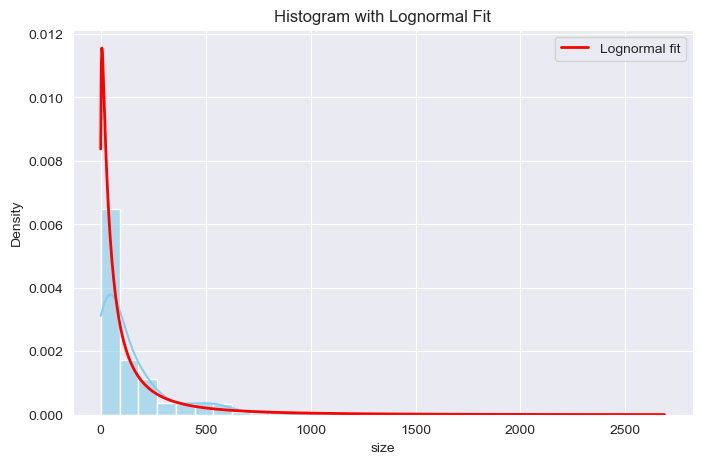

In [10]:
best_fit = stats.lognorm
params = best_fit.fit(data)

x = np.linspace(min(data), max(data), 1000)
pdf = best_fit.pdf(x, *params)

plt.figure(figsize=(8,5))
sns.histplot(data, bins=30, stat="density", color='skyblue', alpha=0.6, kde=True)
plt.plot(x, pdf, 'r-', lw=2, label="Lognormal fit")
plt.legend()
plt.title("Histogram with Lognormal Fit")
plt.show()


In [11]:
# Histogram-based sampling (discrete approximation + inverse transform)
n_sim = df_all_matched.shape[0]
df = df_all_matched.copy()
data = df["size"].dropna()
counts, bin_edges = np.histogram(data, bins=20000)
probs = counts / counts.sum()
# sample bin indices then uniform inside bin
bin_idx = np.random.choice(len(probs), size=n_sim, p=probs)
simulated_size = np.random.uniform(bin_edges[bin_idx], bin_edges[bin_idx+1])

In [12]:
n_sim_size = []
def randomization(df):
    n_sim = df.shape[0]
    bin_idx = np.random.choice(len(probs), size=n_sim, p=probs)
    simulated_size = np.random.uniform(bin_edges[bin_idx], bin_edges[bin_idx+1])
    df["size"] = simulated_size
    return df

In [13]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, randomization)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    n_sim_size.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.000		 - 0.000
1		 - 0.000		 - 0.000


In [14]:
# before Binomial significance test filtration
# number	 - volume share	 - count share
# 0		 - 0.032		 - 0.047
# 1		 - 0.032		 - 0.048

### Size Permutation

In [10]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [11]:
n_sim_perm_size = []

def size_permutation_optimized(df):
    rng = np.random.default_rng()
    df_perm = df.copy()

    df_perm["wallet_id"] = rng.permutation(df_perm["wallet_id"].values)

    out = df_perm.sort_values("time")
    return out

In [12]:
h0_volume = (df_detected["open_size"] + df_detected["close_size"]).sum()
h0_count = df_detected["open_size"].shape[0]

In [14]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, size_permutation_optimized, is_final_filtration=True)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    n_sim_perm_size.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.642		 - 1.883
1		 - 0.642		 - 1.872


In [ ]:
# before Binomial significance test filtration
# number	 - volume share	 - count share
# 0		 - 0.654		 - 1.921
# 1		 - 0.652		 - 1.909

### Seller Buyer randomization

In [20]:
store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [21]:
n_sim_seller_buyer = []

def block_and_side_permutation_optimized(df):
    rng = np.random.default_rng()
    df_perm = df.copy()

    def permute_column(x):
        return rng.permutation(x.values)

    df_perm["wallet_id"] = df_perm.groupby(["side"], sort=False)["wallet_id"].transform(permute_column)

    # 4. Clean up and sort
    out = df_perm.sort_values("time")
    return out

In [22]:
h0_volume = (df_detected["open_size"] + df_detected["close_size"]).sum()
h0_count = df_detected["open_size"].shape[0]

In [23]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, block_and_side_permutation_optimized)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    n_sim_seller_buyer.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share
0		 - 0.393		 - 1.249
1		 - 0.414		 - 1.256


In [24]:
# before Binomial significance test filtration
# number	 - volume share	 - count share
# 0		 - 0.846		 - 1.870
# 1		 - 0.865		 - 1.881

### seller buyer randomization per block of 5 minutes

In [5]:
n_sim_seller_buyer_block = []

def block_and_side_permutation_optimized(df, block_seconds=60*60*24*30, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    df_perm = df.copy()

    df_perm["block_id"] = (df_perm["time"].astype("int64") // (block_seconds * 1_000_000_000))

    def permute_column(x):
        return rng.permutation(x.values)

    df_perm["wallet_id"] = df_perm.groupby(["block_id", "side"], sort=False)["wallet_id"].transform(permute_column)

    # 4. Clean up and sort
    out = df_perm.sort_values("time").drop(columns="block_id")
    return out


In [6]:
print(f"number\t - volume share\t - count share")
for i in range(2):
    sim_time_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, block_and_side_permutation_optimized)

    sim_time_detected_share_volume = (sim_time_detected["open_size"] + sim_time_detected["close_size"]).sum() / h0_volume
    sim_time_detected_share_count = sim_time_detected["open_size"].shape[0] / h0_count
    n_sim_seller_buyer_block.append(sim_time_detected)
    print(f"{i}\t\t - {sim_time_detected_share_volume:.{3}f}\t\t - {sim_time_detected_share_count:.{3}f}")

number	 - volume share	 - count share


NameError: name 'h0_volume' is not defined

In [27]:
# before Binomial significance test filtration
# number	 - volume share	 - count share
# 0		 - 0.862		 - 1.895
# 1		 - 0.857		 - 1.878

In [ ]:
m

In [ ]:
from src.simple_wash_detector_utils import _to_long_per_wallet, _aggregate_microfills_long

long_df = _to_long_per_wallet(df_all_matched)

# B) Aggregate micro-fills
agg = _aggregate_microfills_long(long_df)

agg = block_and_side_permutation_optimized(agg)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_wallet_balance(df, wallet_id, start_date_str, n_days=7, shift_days=0):
    """
    Plot accumulated token balance for a wallet over a specific time window,
    keeping balance constant between trades (step-like timeline).
    """

    # Ensure time column is timezone-aware
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Define date window
    start_date = pd.to_datetime(start_date_str, utc=True) + pd.Timedelta(days=shift_days)
    end_date = start_date + pd.Timedelta(days=n_days)

    # Filter for wallet and date range
    mask = (df['wallet_id'] == wallet_id) & (df['time'].between(start_date, end_date))
    df_wallet = df.loc[mask].copy()

    if df_wallet.empty:
        print(f"No data found for wallet {wallet_id} between {start_date.date()} and {end_date.date()}.")
        return

    # Sort by time
    df_wallet = df_wallet.sort_values('time')

    # Compute signed size and cumulative balance
    df_wallet['signed_size'] = np.where(df_wallet['is_ask'], -df_wallet['size'], df_wallet['size'])
    df_wallet['balance'] = df_wallet['signed_size'].cumsum()

    # Add previous balance at start and fill forward to create step plot
    df_wallet = pd.concat([
        pd.DataFrame({'time': [start_date], 'balance': [0]}),
        df_wallet[['time', 'balance']]
    ]).sort_values('time')

    # Fill forward to show constant balance between trades
    df_wallet['balance'] = df_wallet['balance'].ffill()

    # Add last point to extend flat line to end_date
    df_wallet = pd.concat([
        df_wallet,
        pd.DataFrame({'time': [end_date], 'balance': [df_wallet['balance'].iloc[-1]]})
    ])

    # Plot as a step plot
    plt.figure(figsize=(10, 5))
    plt.step(df_wallet['time'], df_wallet['balance'], where='post', linewidth=2)
    plt.scatter(df_wallet['time'], df_wallet['balance'], color='white', s=20, zorder=3, alpha=0.7)
    plt.title(f"Token Balance Over Time (Step Plot)\nWallet: {wallet_id}\n{start_date.date()} → {end_date.date()}")
    plt.xlabel("Time")
    plt.ylabel("Token Balance")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return df_wallet

In [ ]:
i = 0

In [ ]:
df_wallet = plot_wallet_balance(agg, 8, "2025-03-22", n_days=10, shift_days=10*i)
df_wallet = plot_wallet_balance(df_all, 8, "2025-03-22", n_days=10, shift_days=10*i)
i+=1

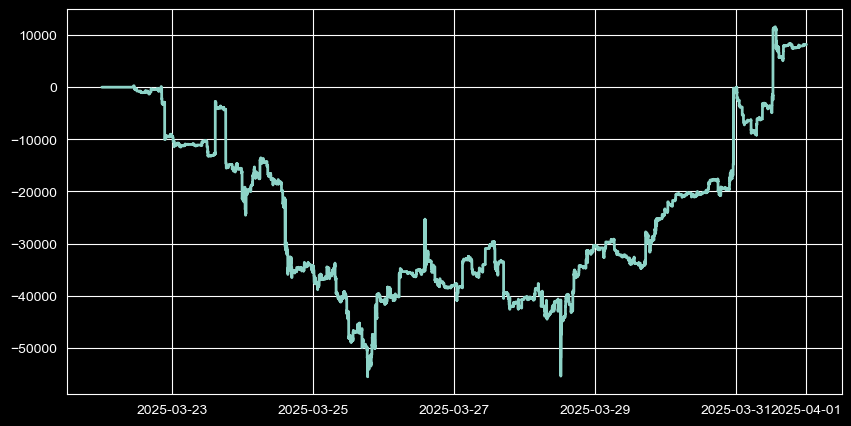

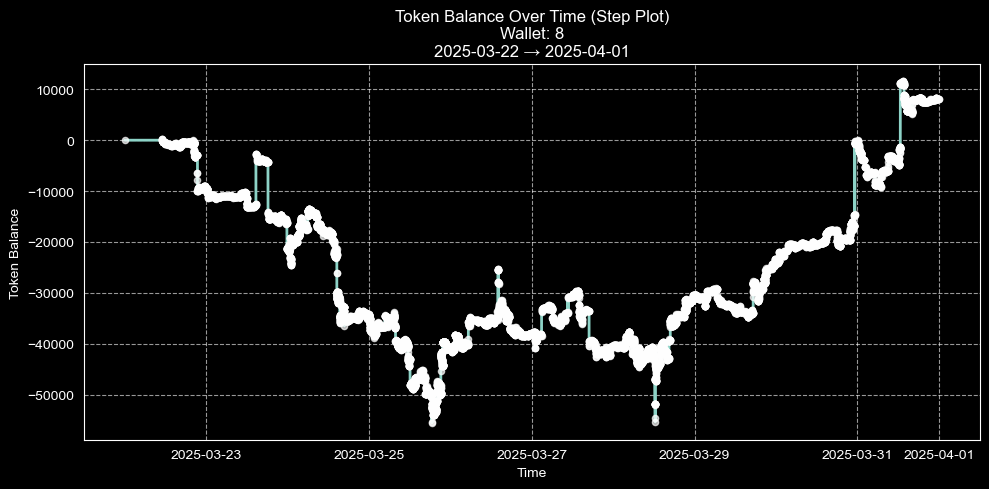

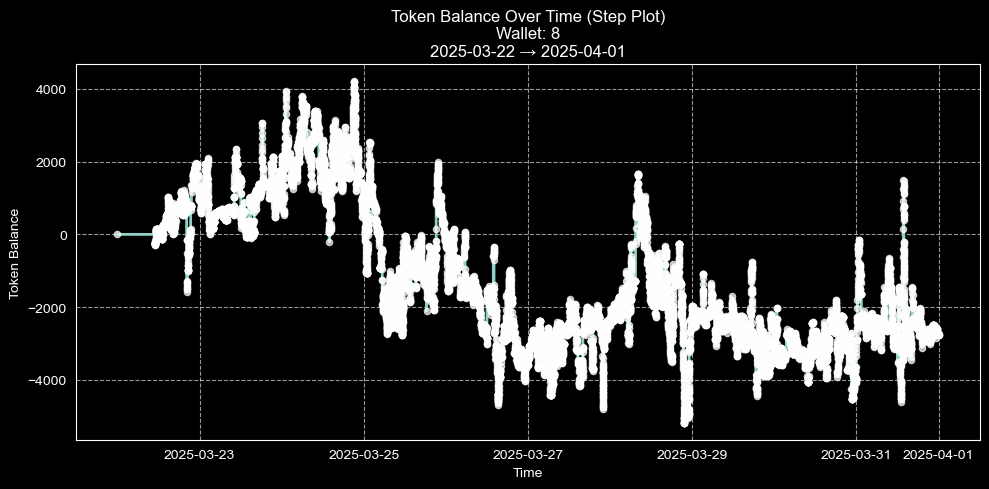

In [25]:
df_wallet = plot_wallet_balance(agg, 8, "2025-03-22", n_days=10, shift_days=10*i)
df_wallet = plot_wallet_balance(df_all, 8, "2025-03-22", n_days=10, shift_days=10*i)
i+=1

<Axes: >

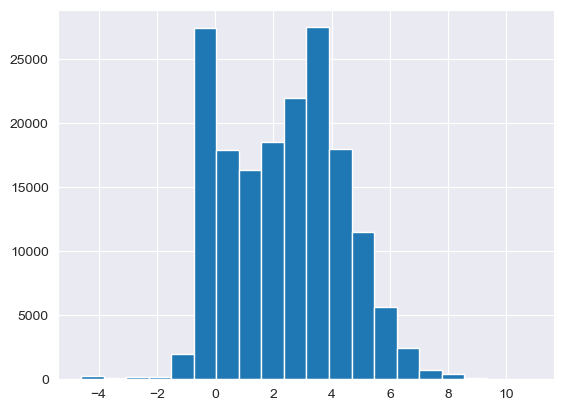

In [55]:
np.log(agg[agg["wallet_id"] == 8]["size"]).hist(bins=20)

<Axes: >

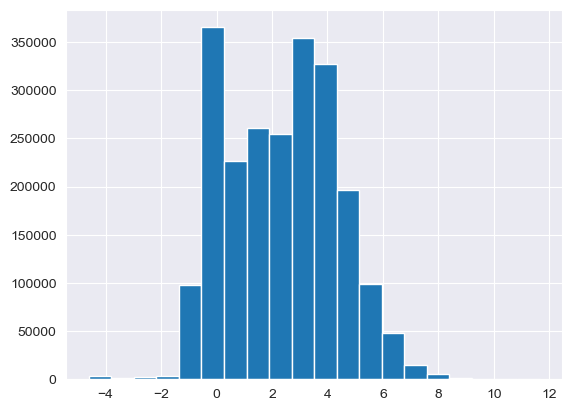

In [61]:
np.log(agg["size"]).hist(bins=20)

In [68]:
df_all["size"].median(), df_detected["open_size"].median(), sim_time_detected["open_size"].median()

(11.670000076293945, 6.295000076293945, 4.0)

<Axes: >

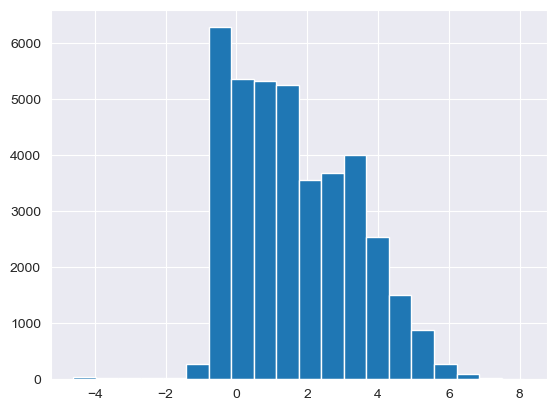

In [83]:
np.log(sim_time_detected["open_size"]).hist(bins=20)

<Axes: >

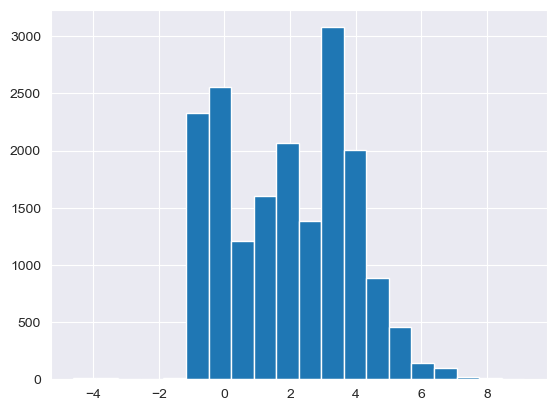

In [84]:
np.log(df_detected["open_size"]).hist(bins=20)

<Axes: >

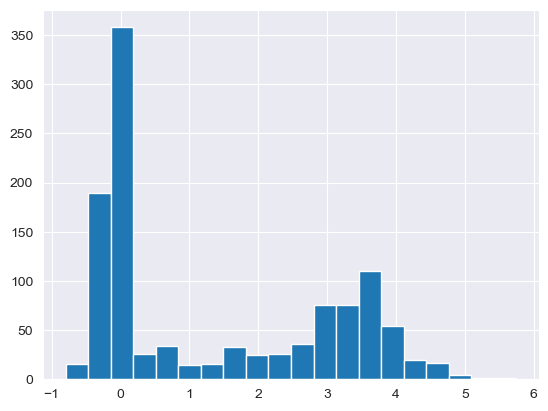

In [87]:
np.log(df_detected[df_detected["wallet_id"] == 8]["open_size"]).hist(bins=20)

<Axes: >

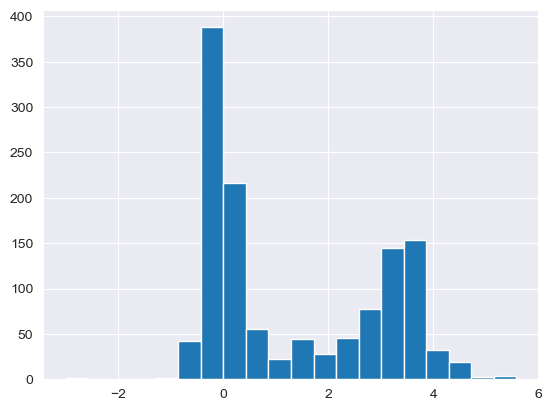

In [88]:
np.log(df_detected[df_detected["wallet_id"] == 19]["open_size"]).hist(bins=20)

<Axes: >

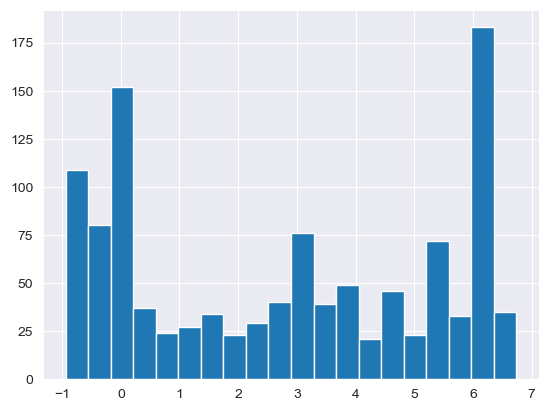

In [89]:
np.log(df_detected[df_detected["wallet_id"] == 161]["open_size"]).hist(bins=20)

In [ ]:
np.log(agg[agg["wallet_id"] == 8]["size"]).hist(bins=20)

In [86]:
agg.groupby("wallet_id")["side"].count().sort_values()

wallet_id
2684         1
2817         1
2769         1
3098         1
4969         1
         ...  
22       79521
88       97032
161     138986
8       170973
19      189023
Name: side, Length: 10635, dtype: int64

## Significance test

In [37]:
# store = CoinDataStore("AVAX", engine="fastparquet")
# df_all_matched = store.load_days(store.list_days()[:50])
# df_all_matched

store = CoinDataStore("AVAX", engine="fastparquet")
df_all_matched = store.load_all()
df_all_matched

,price,size,time,seller,buyer
0,19.521999,213.199997,2025-03-22 10:50:22.930512310,8,658
1,19.521999,1.000000,2025-03-22 10:50:23.731759790,19,658
2,19.525999,11.820000,2025-03-22 10:50:43.490273671,161,1260
3,19.525999,39.150002,2025-03-22 10:50:43.490273671,161,19500
4,19.525000,8.800000,2025-03-22 10:50:43.490273671,161,240
...,...,...,...,...,...
1478242,24.966999,1.210000,2025-07-27 08:44:33.762000000,8,1527
1478243,24.971001,308.359985,2025-07-27 08:44:59.437000000,161,5135
1478244,24.971001,203.639999,2025-07-27 08:44:59.437000000,892,5135
1478245,24.971001,11.940000,2025-07-27 08:45:07.130000000,19,170117


In [38]:
import numpy as np

def compute_metrics(df_detected, h0_volume, h0_count):
    """
    Compute wash-trading metrics.
    """
    wash_vol = (df_detected["open_size"] + df_detected["close_size"]).sum()
    wash_cnt = len(df_detected)
    return {
        "wash_volume_share": wash_vol / h0_volume,
        "wash_count_share": wash_cnt / h0_count,
        "wash_volume": wash_vol,
        "wash_count": wash_cnt
    }

In [10]:
sim = []

def block_and_side_permutation_optimized(df, block_seconds=60*60*24*30, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    df_perm = df.copy()

    df_perm["block_id"] = (df_perm["time"].astype("int64") // (block_seconds * 1_000_000_000))

    def permute_column(x):
        return rng.permutation(x.values)

    df_perm["wallet_id"] = df_perm.groupby(["block_id", "side"], sort=False)["wallet_id"].transform(permute_column)

    # 4. Clean up and sort
    out = df_perm.sort_values("time").drop(columns="block_id")
    return out


In [44]:
null_vol_shares = []
null_cnt_shares = []

for i in range(50):
    sim_detected = detect_wash_trades_local(df_all_matched, time_diff_s, price_diff_pct, size_diff_pct, block_and_side_permutation_optimized)
    sim.append(sim_detected)
    m = compute_metrics(sim_detected, h0_volume, h0_count)
    null_vol_shares.append(m["wash_volume_share"])
    null_cnt_shares.append(m["wash_count_share"])
    print(f"{i:03d}: volume={m['wash_volume_share']:.4f}  count={m['wash_count_share']:.4f}")

obs_metrics = compute_metrics(df_detected, h0_volume, h0_count)


000: volume=0.8671  count=1.8877
001: volume=0.8320  count=1.8857
002: volume=0.8767  count=1.8959
003: volume=0.8400  count=1.8903
004: volume=0.8501  count=1.8691
005: volume=0.8395  count=1.8868
006: volume=0.8367  count=1.8732
007: volume=0.8636  count=1.8791
008: volume=0.8619  count=1.8760
009: volume=0.8454  count=1.8884
010: volume=0.8601  count=1.8883
011: volume=0.8744  count=1.8874
012: volume=0.8482  count=1.8683
013: volume=0.8529  count=1.8812
014: volume=0.8396  count=1.8770
015: volume=0.8523  count=1.8897
016: volume=0.8350  count=1.8752
017: volume=0.8377  count=1.8734
018: volume=0.8466  count=1.8833
019: volume=0.8850  count=1.8866
020: volume=0.8491  count=1.8572
021: volume=0.8810  count=1.8890
022: volume=0.8623  count=1.8811
023: volume=0.8557  count=1.8742
024: volume=0.8506  count=1.8627
025: volume=0.8360  count=1.8860
026: volume=0.8732  count=1.8761
027: volume=0.8622  count=1.8870
028: volume=0.8859  count=1.8876
029: volume=0.8460  count=1.8751
030: volum

In [46]:
def summarize_significance(obs, nulls):
    nulls = np.array(nulls)
    p = (1 + np.sum(nulls >= obs)) / (len(nulls) + 1)
    z = (obs - nulls.mean()) / nulls.std()
    excess_ratio = obs / nulls.mean()
    return {
        "obs": obs,
        "mean_null": nulls.mean(),
        "std_null": nulls.std(),
        "p_value": p,
        "z_score": z,
        "excess_ratio": excess_ratio
    }

vol_stats = summarize_significance(obs_metrics["wash_volume_share"], null_vol_shares)
cnt_stats = summarize_significance(obs_metrics["wash_count_share"], null_cnt_shares)

print("=== Volume-based metric ===")
for k,v in vol_stats.items():
    print(f"{k:15s}: {v:.5f}" if isinstance(v,(float,int)) else f"{k:15s}: {v}")

print("\n=== Count-based metric ===")
for k,v in cnt_stats.items():
    print(f"{k:15s}: {v:.5f}" if isinstance(v,(float,int)) else f"{k:15s}: {v}")

=== Volume-based metric ===
obs            : 1.0
mean_null      : 0.8554259538650513
std_null       : 0.014908045530319214
p_value        : 0.01961
z_score        : 9.69771957397461
excess_ratio   : 1.1690082550048828

=== Count-based metric ===
obs            : 1.00000
mean_null      : 1.88093
std_null       : 0.00852
p_value        : 1.00000
z_score        : -103.34984
excess_ratio   : 0.53165


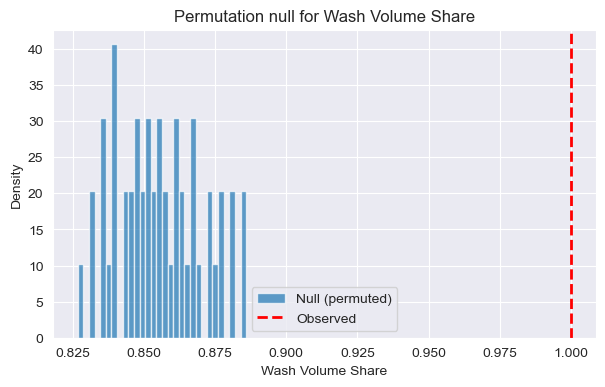

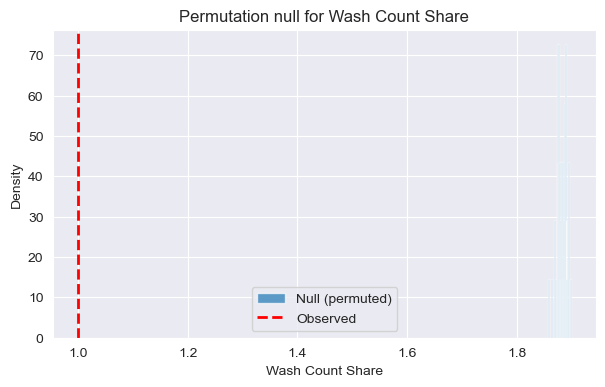

In [47]:
import matplotlib.pyplot as plt

def diagnostic_plots(null_values, obs_value, metric_name="wash_volume_share"):
    null_values = np.array(null_values)
    plt.figure(figsize=(7,4))
    plt.hist(null_values, bins=30, alpha=0.7, label="Null (permuted)", density=True)
    plt.axvline(obs_value, color="red", linestyle="--", lw=2, label="Observed")
    plt.title(f"Permutation null for {metric_name}")
    plt.xlabel(metric_name)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# example plots
diagnostic_plots(null_vol_shares, obs_metrics["wash_volume_share"], "Wash Volume Share")
diagnostic_plots(null_cnt_shares, obs_metrics["wash_count_share"], "Wash Count Share")

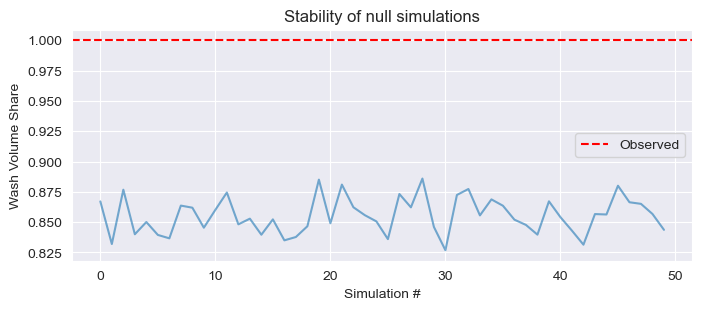

In [48]:
plt.figure(figsize=(8,3))
plt.plot(null_vol_shares, alpha=0.6)
plt.axhline(obs_metrics["wash_volume_share"], color="red", linestyle="--", label="Observed")
plt.xlabel("Simulation #")
plt.ylabel("Wash Volume Share")
plt.title("Stability of null simulations")
plt.legend()
plt.show()


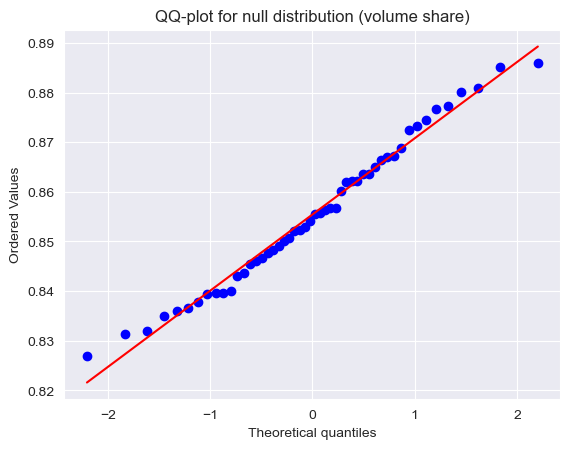

In [49]:
import scipy.stats as st
st.probplot(null_vol_shares, dist="norm", plot=plt)
plt.title("QQ-plot for null distribution (volume share)")
plt.show()


In [68]:
volumes = [simulation.groupby("wallet_id")["open_size"].sum() * 2 for simulation in sim]
counts = [simulation.groupby("wallet_id")["open_size"].count() for simulation in sim]
h0_volume = df_detected.groupby("wallet_id")["open_size"].sum()
h0_count = df_detected.groupby("wallet_id")["open_size"].count()

In [103]:
df_vol = pd.merge(
    df_all_matched.groupby("seller")["size"].sum().reset_index().rename({"seller": "wallet_id"}, axis=1),
    df_all_matched.groupby("buyer")["size"].sum().reset_index().rename({"buyer": "wallet_id"}, axis=1),
    on="wallet_id"
).set_index("wallet_id").sum(axis=1)

df_count = pd.merge(
    df_all_matched.groupby("seller")["size"].count().reset_index().rename({"seller": "wallet_id"}, axis=1),
    df_all_matched.groupby("buyer")["size"].count().reset_index().rename({"buyer": "wallet_id"}, axis=1),
    on="wallet_id"
).set_index("wallet_id").sum(axis=1)

In [114]:
simulation_stats = pd.concat([
    pd.concat(volumes, axis=1).fillna(0).mean(axis=1),
    pd.concat(volumes, axis=1).fillna(0).std(axis=1),
    pd.concat(counts, axis=1).fillna(0).mean(axis=1),
    pd.concat(counts, axis=1).fillna(0).std(axis=1),
    df_vol,
    df_count
], axis=1).rename({0: "volume_mean", 1: "volume_std", 2: "count_mean", 3: "count_std", 4: "vol", 5: "count"}, axis=1).fillna(0)
simulation_stats

,volume_mean,volume_std,count_mean,count_std,vol,count
wallet_id,,,,,,
3,1043.855469,769.600525,16.74,5.086236,7.119979e+05,6790
5,285.760437,323.280670,4.12,2.105774,1.014698e+05,2572
6,408.960327,302.902893,7.34,2.767228,1.601482e+05,3904
7,770.448853,369.925507,16.18,4.331611,2.168302e+05,6697
8,339489.468750,15952.784180,7456.68,81.158811,4.276013e+06,194892
...,...,...,...,...,...,...
271551,0.000000,0.000000,0.00,0.000000,7.225999e+01,3
271895,0.000000,0.000000,0.00,0.000000,6.377200e+02,18
272337,0.000000,0.000000,0.00,0.000000,1.193200e+02,4


In [115]:
simulation_stats["smth"] = simulation_stats["volume_mean"] / simulation_stats["volume_std"]

In [116]:
simulation_stats[simulation_stats["volume_mean"] > 1000].sort_values("smth").head(30)

,volume_mean,volume_std,count_mean,count_std,vol,count,smth
wallet_id,,,,,,,
613,1111.188354,954.638672,17.58,3.569085,1.971173e+05,5137,1.163988
62,1028.428101,872.373657,22.44,4.314948,1.557029e+06,7852,1.178885
29,7826.332031,5816.264648,171.86,13.543596,1.169345e+06,27139,1.345594
3,1043.855469,769.600525,16.74,5.086236,7.119979e+05,6790,1.356360
113,1479.310181,1052.227539,36.12,6.355586,6.819198e+05,8990,1.405884
1369,1401.359985,908.228088,27.94,5.381032,1.099669e+06,8960,1.542960
625,1015.571716,624.913269,20.62,4.650609,6.049852e+04,3429,1.625140
14952,1413.344482,815.928101,28.82,4.529675,4.382404e+04,6449,1.732192
711,1023.557434,561.396362,20.68,4.744234,6.379501e+04,3665,1.823235


In [117]:
simulation_stats["stat"] = simulation_stats["volume_mean"] / simulation_stats["count"]

In [122]:
simulation_stats[simulation_stats["stat"] > 0.1].sort_values("stat")

,volume_mean,volume_std,count_mean,count_std,vol,count,smth,stat
wallet_id,,,,,,,,
28259,0.020400,0.144250,0.02,0.141421,5.274400e+02,20,0.141421,0.001020
160279,0.198400,1.040164,0.04,0.197949,6.881500e+02,190,0.190739,0.001044
218572,0.027200,0.192333,0.02,0.141421,2.678000e+01,26,0.141421,0.001046
14291,0.033600,0.237588,0.02,0.141421,5.759000e+02,32,0.141421,0.001050
40272,0.045600,0.322441,0.02,0.141421,1.179980e+03,43,0.141421,0.001060
...,...,...,...,...,...,...,...,...
19,403652.750000,14845.574219,8877.60,85.705238,4.486442e+06,214792,27.190107,1.879273
3269,24.199200,171.114227,0.02,0.141421,8.000000e+02,11,0.141421,2.199927
88464,4.592000,32.470345,0.02,0.141421,4.560000e+00,2,0.141421,2.296000


<Axes: ylabel='Frequency'>

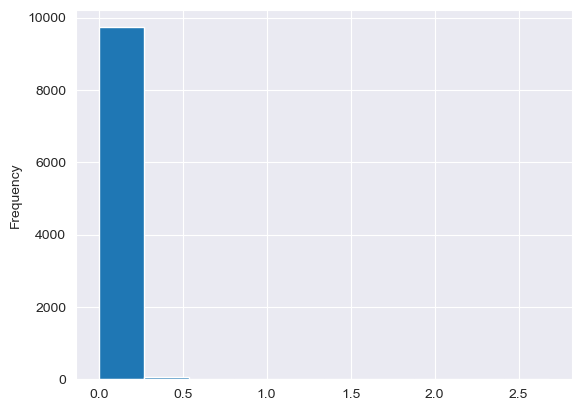

In [124]:
simulation_stats["stat"].plot.hist()